In [186]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime
import re
import string
import scipy.spatial.distance as ds
from sklearn.feature_extraction.text import HashingVectorizer
from tqdm import tqdm

In [187]:
# Data path
main_path = 'C:\\Users\\MyPC\\Desktop\\vs py\\Innowise HW\\1. Data\\'

In [188]:
def get_files_list(main_path):
    
    files_dict = {}
    files_list = os.listdir(main_path)
    
    for file in files_list:
        file_name = file.split('.csv')[0]
        files_dict[file_name] = file
        
    print(files_dict)   
    
    return files_dict

def get_df(path):
    
    df_path = os.path.join(main_path, path)
    df = pd.read_csv(df_path)
    
    return df

def get_numeric_columns(df):
    
    numeric_columns  = df.select_dtypes(include=['int64', 'float64']).columns
    print(numeric_columns)
    
    return numeric_columns

def get_object_columns(df):
    
    object_columns  = df.select_dtypes(include='object').columns
    print(object_columns)
    
    return object_columns

def data_representation(separated_df, column_name):
    
    flag = False
    
    unique_values_in_train = united_train_data[column_name].unique().tolist()
    base_values = separated_df[column_name].unique().tolist()
    
    for i in unique_values_in_train:
        if i not in base_values:
            print(i)
            flag = True
            
    if flag == False:
        print('All the unique values represented in data')

        
def symbol_filter(record):
    
    power_numbers = ['⁰', '¹', '²', '³', '⁴', '⁵', '⁶', '⁷', '⁸', '⁹']
    record = ''.join(map(str, [i for i in record if i not in string.punctuation and i not in power_numbers]))
    return record


def vectorization_text(records):
    
    new_vectors = records.copy()
    vectorizer = HashingVectorizer(n_features=19)
    
    for i in range(len(new_vectors)):
        vector = vectorizer.transform([new_vectors.iloc[i]])
        new_vectors.iloc[i] = vector.toarray()[0]
        
    return new_vectors


def distance(vec1, vec2):
    return (1 - ds.cosine(vec1, vec2))
    

def distance_between_vectors(df):
    
    distances = {}
    
    for i in tqdm(range(0, len(df) - 1)):
        for j in range(i+1, len(df)):
            if distance(df[i], df[j]) >= 0.75:
                if i not in distances:
                    distances[i] = [j]
                else:
                    distances[i].append(j)
    
    return distances


def similar_vectors(vectors_difference, df, colum_name):
    
    for key in vectors_difference:
        print(key, df.iloc[key][colum_name])
        print(df.iloc[vectors_difference[key]][colum_name])
        print('==================')
        
        
def check_records_duplicates(df, colum_name):
    
    df_copy = df.copy()
    
    for i in range(len(df_copy)):
        df_copy[colum_name].iloc[i] = symbol_filter(df_copy[colum_name].iloc[i])
    
    df_copy[colum_name] = vectorization_text(df_copy[colum_name])
    
    vectors_difference = distance_between_vectors(df_copy[colum_name])
    similar_vectors(vectors_difference, df, colum_name)
    
    
def duplicate_sales(df, shop_id, shop_id_dup):
    
    main_shop_sales = df[df['shop_id'] == shop_id].groupby('date_block_num').agg({'item_cnt_day': 'count'}).reset_index()
    duplicate_shop_sales = df[df['shop_id'] == shop_id_dup].groupby('date_block_num').agg({'item_cnt_day': 'count'}).reset_index()
        
    name_main_shop = df.iloc[shop_id]['shop_name']
    name_duplicate_shop = df.iloc[shop_id_dup]['shop_name']
    
    plt.figure(figsize=(10, 5))
    plt.plot(main_shop_sales['date_block_num'], main_shop_sales['item_cnt_day'], 
                                     label = f'{name_main_shop}, id: {shop_id}')
    
    plt.plot(duplicate_shop_sales['date_block_num'], duplicate_shop_sales['item_cnt_day'], 
                                     label = f'{name_duplicate_shop}, id: {shop_id_dup}')
    plt.legend()
    plt.show()

In [189]:
file_dict = get_files_list(main_path)

{'items': 'items.csv', 'item_categories': 'item_categories.csv', 'sales_train': 'sales_train.csv', 'sample_submission': 'sample_submission.csv', 'shops': 'shops.csv', 'test': 'test.csv'}


In [190]:
sales_train_df = get_df(file_dict['sales_train'])
item_df = get_df(file_dict['items'])
item_category_df = get_df(file_dict['item_categories'])
sample_submission_df = get_df(file_dict['sample_submission'])
shops_df = get_df(file_dict['shops'])
test_df = get_df(file_dict['test'])

# Sales train data

In [191]:
sales_train_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [192]:
sales_train_df.shape

(2935849, 6)

In [193]:
sales_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [194]:
sales_train_df.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


# Item

In [195]:
item_df.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [196]:
item_df.shape

(22170, 3)

In [197]:
item_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


In [198]:
item_df.describe()

,item_id,item_category_id
count,22170.00000,22170.000000
mean,11084.50000,46.290753
std,6400.07207,15.941486
min,0.00000,0.000000
25%,5542.25000,37.000000
50%,11084.50000,40.000000
75%,16626.75000,58.000000
max,22169.00000,83.000000


# Item category

In [199]:
item_category_df.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [200]:
item_category_df.shape

(84, 2)

In [201]:
item_category_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


In [202]:
item_category_df.describe()

,item_category_id
count,84.000000
mean,41.500000
std,24.392622
min,0.000000
25%,20.750000
50%,41.500000
75%,62.250000
max,83.000000


# Shops

In [203]:
shops_df.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [204]:
shops_df.shape

(60, 2)

In [205]:
shops_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [206]:
shops_df.describe()

,shop_id
count,60.000000
mean,29.500000
std,17.464249
min,0.000000
25%,14.750000
50%,29.500000
75%,44.250000
max,59.000000


# Test 

In [207]:
test_df.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [208]:
test_df.shape

(214200, 3)

In [209]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   ID       214200 non-null  int64
 1   shop_id  214200 non-null  int64
 2   item_id  214200 non-null  int64
dtypes: int64(3)
memory usage: 4.9 MB


# Merge train data

In [210]:
item_and_category = item_df.copy(deep=True)
item_and_category = item_and_category.merge(item_category_df, on='item_category_id', how = 'left')

united_train_data = sales_train_df.copy(deep=True)
united_train_data = united_train_data.merge(shops_df, on = 'shop_id', how = 'left')
united_train_data = united_train_data.merge(item_and_category, on = 'item_id')

In [211]:
united_train_data

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
0,02.01.2013,0,59,22154,999.0,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,23.01.2013,0,24,22154,999.0,1.0,"Москва ТК ""Буденовский"" (пав.К7)",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
2,20.01.2013,0,27,22154,999.0,1.0,"Москва ТЦ ""МЕГА Белая Дача II""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
3,02.01.2013,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
4,03.01.2013,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
...,...,...,...,...,...,...,...,...,...,...
2935844,17.10.2015,33,25,8428,249.0,1.0,"Москва ТРК ""Атриум""","АХ, ВОДЕВИЛЬ, ВОДЕВИЛЬ (rem)",40,Кино - DVD
2935845,01.10.2015,33,25,7903,12198.0,1.0,"Москва ТРК ""Атриум""",XBOX 360 S 250GB CONSOLE/KINECT BUNDLE KUNG FU...,15,Игровые консоли - XBOX 360
2935846,29.10.2015,33,25,7610,2890.0,1.0,"Москва ТРК ""Атриум""",WARHAMMER ACCESSORIES: Khorne Dice арт. 65-13,64,Подарки - Настольные игры
2935847,22.10.2015,33,25,7635,2100.0,1.0,"Москва ТРК ""Атриум""",WARHAMMER MINIATURES: Dark Elf Doomfire Warloc...,64,Подарки - Настольные игры


# Numeric / object columns

In [212]:
get_numeric_columns(united_train_data)
get_object_columns(united_train_data)

Index(['date_block_num', 'shop_id', 'item_id', 'item_price', 'item_cnt_day',
       'item_category_id'],
      dtype='object')
Index(['date', 'shop_name', 'item_name', 'item_category_name'], dtype='object')


Index(['date', 'shop_name', 'item_name', 'item_category_name'], dtype='object')

# Missings records

In [213]:
united_train_data.isnull().sum()

date                  0
date_block_num        0
shop_id               0
item_id               0
item_price            0
item_cnt_day          0
shop_name             0
item_name             0
item_category_id      0
item_category_name    0
dtype: int64

# Numeric data split to explore
1. Shop_id, item_id, item_cat - Representation in train
2. Item_price, item_cnt_day - Outliers, zeros, negative values

# 1. Representation of shops, items and categories in train df

# Shop_id

In [214]:
data_representation(shops_df, 'shop_id')

All the unique values represented in data


# item_id

In [215]:
data_representation(item_df, 'item_id')

All the unique values represented in data


# item_cat

In [216]:
data_representation(item_category_df, 'item_category_id')

All the unique values represented in data


# 2. Outliers, zeros, negative values in item_price and item_cnt_day

# 2.1.1 item_cnt_day - Outliers

<AxesSubplot: xlabel='item_cnt_day'>

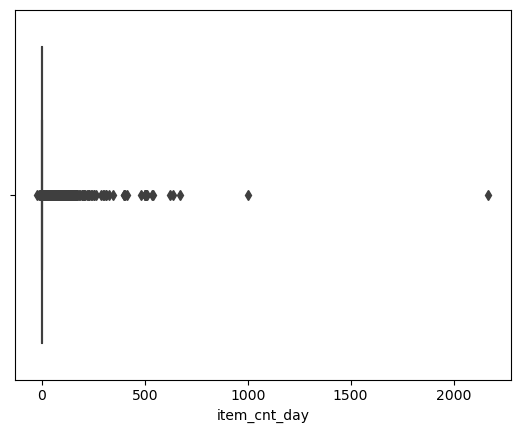

In [217]:
sns.boxplot(x=united_train_data['item_cnt_day'])

In [218]:
united_train_data[united_train_data['item_cnt_day'] > 900]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
1181188,28.10.2015,33,12,11373,0.908714,2169.0,Интернет-магазин ЧС,Доставка до пункта выдачи (Boxberry),9,Доставка товара
1494614,15.01.2015,24,12,20949,4.000000,1000.0,Интернет-магазин ЧС,Фирменный пакет майка 1С Интерес белый (34*42)...,71,"Подарки - Сумки, Альбомы, Коврики д/мыши"


# 2.1.2 item_cnt_day - zeros

In [219]:
united_train_data[united_train_data['item_cnt_day'] == 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name


# 2.1.3 item_cnt_day - Negative values

In [220]:
united_train_data[united_train_data['item_cnt_day'] < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
60,05.01.2013,0,25,2552,899.0,-1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
64,14.05.2013,4,6,2552,949.0,-1.0,"Воронеж (Плехановская, 13)",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
1985,07.07.2014,18,31,2574,399.0,-1.0,"Москва ТЦ ""Семеновский""",DEL REY LANA Born To Die The Paradise Editio...,55,Музыка - CD локального производства
2543,26.06.2015,29,16,2574,449.0,-1.0,"Коломна ТЦ ""Рио""",DEL REY LANA Born To Die The Paradise Editio...,55,Музыка - CD локального производства
2557,11.07.2015,30,42,2574,449.0,-1.0,"СПб ТК ""Невский Центр""",DEL REY LANA Born To Die The Paradise Editio...,55,Музыка - CD локального производства
...,...,...,...,...,...,...,...,...,...,...
2934862,25.10.2015,33,48,5908,3199.0,-1.0,"Томск ТРЦ ""Изумрудный Город""","Pro Evolution Soccer 2016 [Xbox 360, русские с...",23,Игры - XBOX 360
2935309,31.10.2015,33,47,4056,2999.0,-1.0,"Сургут ТРЦ ""Сити Молл""","Just Dance 2016. Unlimited [Xbox One, русская ...",24,Игры - XBOX ONE
2935585,14.10.2015,33,9,18103,3799.0,-1.0,Выездная Торговля,Рюкзак Batman With Logo с капюшоном,61,Подарки - Атрибутика
2935731,04.10.2015,33,9,21036,1899.0,-1.0,Выездная Торговля,Футболка Bloodborne Bossfight White L,61,Подарки - Атрибутика


# 2.2.1 Item_price - Outliers

<AxesSubplot: xlabel='item_price'>

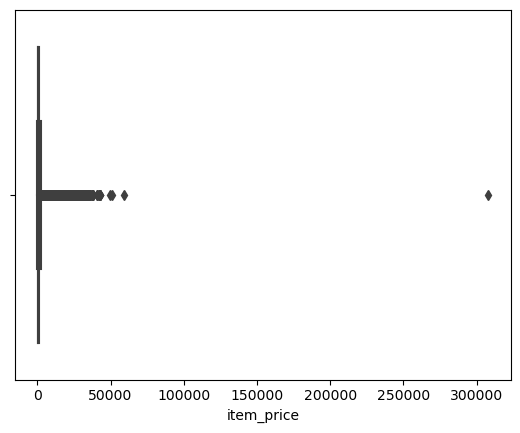

In [221]:
sns.boxplot(x=united_train_data['item_price'])

In [222]:
united_train_data[united_train_data['item_price'] > 300000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
2163826,13.12.2013,11,12,6066,307980.0,1.0,Интернет-магазин ЧС,Radmin 3 - 522 лиц.,75,Программы - Для дома и офиса


# 2.2.2 Item_price - Zeros

In [223]:
united_train_data[united_train_data['item_price'] == 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name


# 2.2.3 Item_price - Negative values

In [224]:
united_train_data[united_train_data['item_price'] < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
56049,15.05.2013,4,32,2973,-1.0,1.0,"Москва ТЦ ""Серебряный Дом""","DmC Devil May Cry [PS3, русские субтитры]",19,Игры - PS3


# Shops duplicate

# List of probable duplicates:

In [225]:
check_records_duplicates(shops_df, 'shop_name')

C:\Users\MyPC\AppData\Local\Temp\ipykernel_10048\3175041208.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy[colum_name].iloc[i] = symbol_filter(df_copy[colum_name].iloc[i])
100%|█████████████████████████████████████████████████████████████████████████████████| 59/59 [00:00<00:00, 630.51it/s]

0 !Якутск Орджоникидзе, 56 фран
57    Якутск Орджоникидзе, 56
Name: shop_name, dtype: object
1 !Якутск ТЦ "Центральный" фран
58    Якутск ТЦ "Центральный"
Name: shop_name, dtype: object
2 Адыгея ТЦ "Мега"
37    Новосибирск ТЦ "Мега"
Name: shop_name, dtype: object
10 Жуковский ул. Чкалова 39м?
11    Жуковский ул. Чкалова 39м²
Name: shop_name, dtype: object
14 Казань ТЦ "ПаркХаус" II
27    Москва ТЦ "МЕГА Белая Дача II"
Name: shop_name, dtype: object
16 Коломна ТЦ "Рио"
18    Красноярск ТЦ "Июнь"
50      Тюмень ТЦ "Гудвин"
Name: shop_name, dtype: object
17 Красноярск ТЦ "Взлетка Плаза"
34    Н.Новгород ТРЦ "РИО"
50      Тюмень ТЦ "Гудвин"
Name: shop_name, dtype: object
18 Красноярск ТЦ "Июнь"
50    Тюмень ТЦ "Гудвин"
Name: shop_name, dtype: object
20 Москва "Распродажа"
29    Москва ТЦ "Новый век" (Новокосино)
Name: shop_name, dtype: object
23 Москва ТК "Буденовский" (пав.А2)
24    Москва ТК "Буденовский" (пав.К7)
Name: shop_name, dtype: object
26 Москва ТЦ "Ареал" (Беляево)
30        Мо

Checking the list of duplicates, we see that some stores are indeed similar:

In [226]:
duplicate_list = [
    [0,57],
    [1,58],
    [10,11],
    [23,24],
    [39,40]
]


for pair in duplicate_list:
    print('\t', shops_df[shops_df['shop_id'] == pair[0]], '\n', shops_df[shops_df['shop_id'] == pair[1]])
    print('=================================')

	                        shop_name  shop_id
0  !Якутск Орджоникидзе, 56 фран        0 
                   shop_name  shop_id
57  Якутск Орджоникидзе, 56       57
	                        shop_name  shop_id
1  !Якутск ТЦ "Центральный" фран        1 
                   shop_name  shop_id
58  Якутск ТЦ "Центральный"       58
	                      shop_name  shop_id
10  Жуковский ул. Чкалова 39м?       10 
                      shop_name  shop_id
11  Жуковский ул. Чкалова 39м²       11
	                            shop_name  shop_id
23  Москва ТК "Буденовский" (пав.А2)       23 
                            shop_name  shop_id
24  Москва ТК "Буденовский" (пав.К7)       24
	                                 shop_name  shop_id
39  РостовНаДону ТРК "Мегацентр Горизонт"       39 
                                           shop_name  shop_id
40  РостовНаДону ТРК "Мегацентр Горизонт" Островной       40


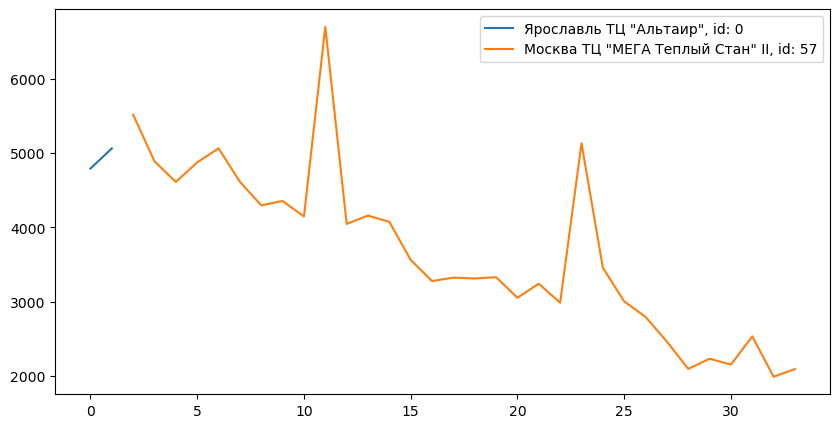

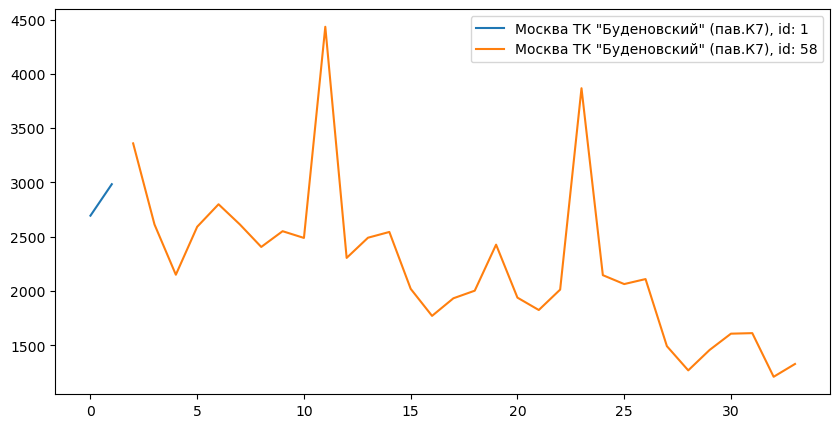

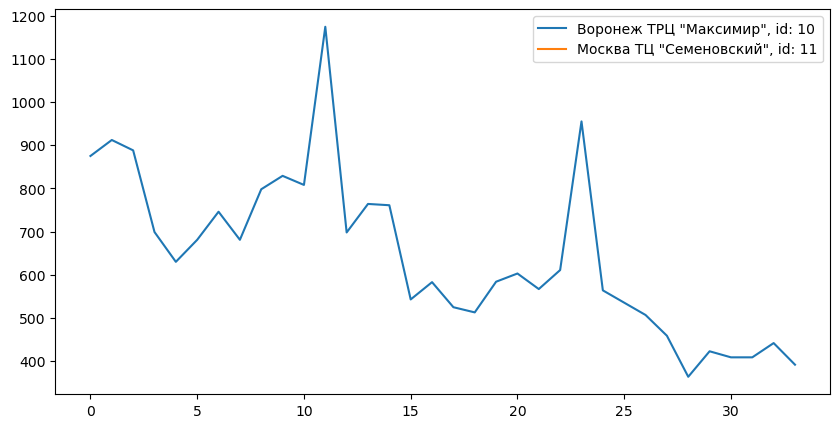

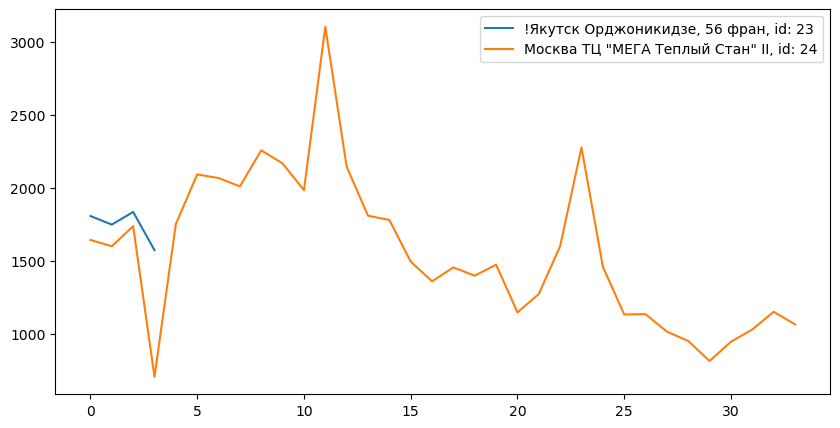

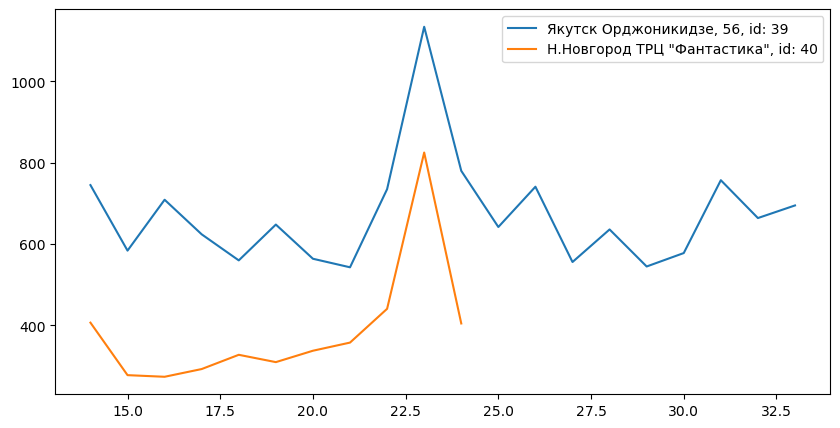

In [227]:
for dup in duplicate_list:
    duplicate_sales(united_train_data, dup[0], dup[1])

# Data preparing 

In [228]:
united_train_data = united_train_data[(united_train_data['item_price'] < 300000) & 
                                      (united_train_data['item_price'] > 0)]

united_train_data = united_train_data[(united_train_data['item_cnt_day'] < 1000) & 
                                      (united_train_data['item_cnt_day'] > 0)]

for pair in duplicate_list:
    united_train_data['shop_id'][united_train_data['shop_id'] == pair[0]] = pair[1]

C:\Users\MyPC\AppData\Local\Temp\ipykernel_10048\703939379.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  united_train_data['shop_id'][united_train_data['shop_id'] == pair[0]] = pair[1]
C:\Users\MyPC\AppData\Local\Temp\ipykernel_10048\703939379.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  united_train_data['shop_id'][united_train_data['shop_id'] == pair[0]] = pair[1]
C:\Users\MyPC\AppData\Local\Temp\ipykernel_10048\703939379.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

In [229]:
united_train_data

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
0,02.01.2013,0,59,22154,999.0,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,23.01.2013,0,24,22154,999.0,1.0,"Москва ТК ""Буденовский"" (пав.К7)",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
2,20.01.2013,0,27,22154,999.0,1.0,"Москва ТЦ ""МЕГА Белая Дача II""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
3,02.01.2013,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
4,03.01.2013,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
...,...,...,...,...,...,...,...,...,...,...
2935844,17.10.2015,33,25,8428,249.0,1.0,"Москва ТРК ""Атриум""","АХ, ВОДЕВИЛЬ, ВОДЕВИЛЬ (rem)",40,Кино - DVD
2935845,01.10.2015,33,25,7903,12198.0,1.0,"Москва ТРК ""Атриум""",XBOX 360 S 250GB CONSOLE/KINECT BUNDLE KUNG FU...,15,Игровые консоли - XBOX 360
2935846,29.10.2015,33,25,7610,2890.0,1.0,"Москва ТРК ""Атриум""",WARHAMMER ACCESSORIES: Khorne Dice арт. 65-13,64,Подарки - Настольные игры
2935847,22.10.2015,33,25,7635,2100.0,1.0,"Москва ТРК ""Атриум""",WARHAMMER MINIATURES: Dark Elf Doomfire Warloc...,64,Подарки - Настольные игры


Text(0.5, 1.0, 'item_cnt_day')

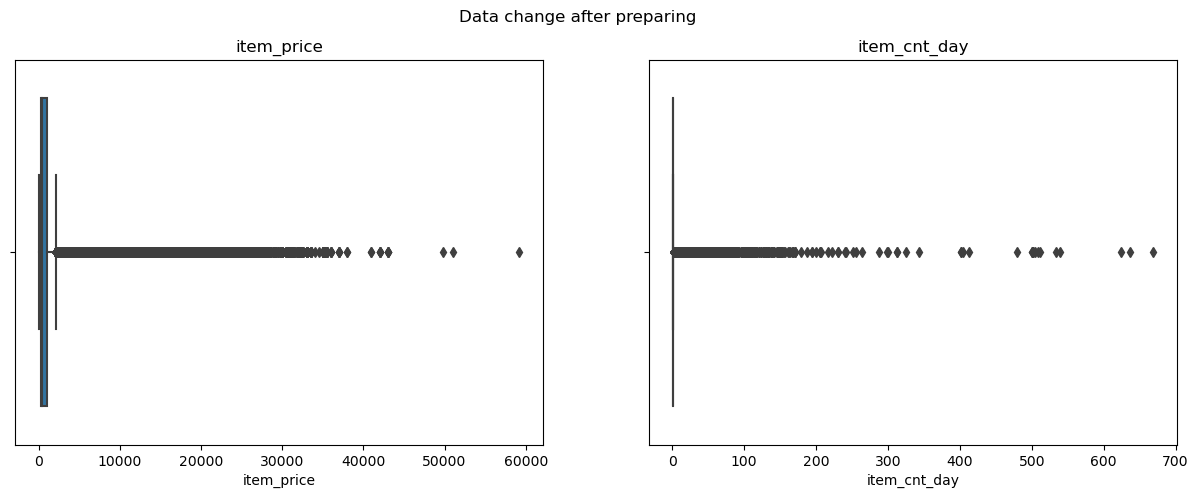

In [230]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle('Data change after preparing')

sns.boxplot(ax=axes[0], x=united_train_data['item_price'])
axes[0].set_title('item_price')

sns.boxplot(ax=axes[1], x=united_train_data['item_cnt_day'])
axes[1].set_title('item_cnt_day')

<function matplotlib.pyplot.show(close=None, block=None)>

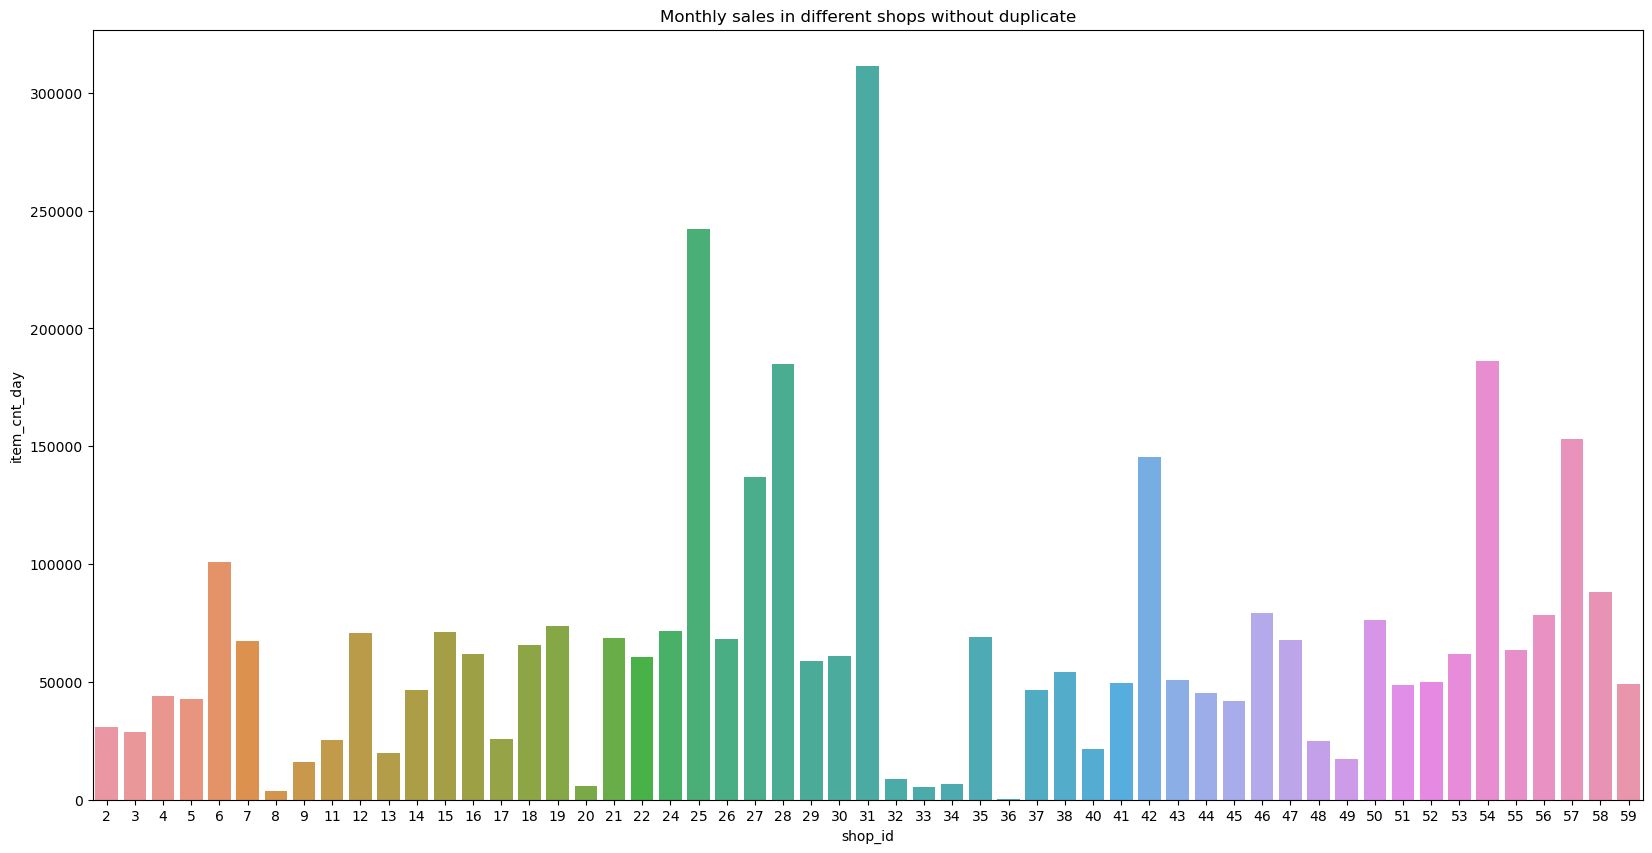

In [231]:
shops = united_train_data.groupby('shop_id').agg({'item_cnt_day': 'sum'}).reset_index()

plt.figure(figsize=(20,10))
hist = sns.barplot(x = shops['shop_id'], y = shops['item_cnt_day'])

plt.title('Monthly sales in different shops without duplicate')
plt.show  